In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [10]:
# Checking what the data looks like for the measurements table
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fc35679f310>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [11]:
# Checking what the data looks like for the stations table
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fc3567a9b50>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [12]:
# Using the inspector to print the column names within the 'measurment' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [14]:
# #Emoji examples to look at for converting to a pandas dataframe and charting
# # Query Emojis for `emoji_char`, `emoji_id`, and `score` and save the query into results
# results = session.query(Emoji.emoji_char, Emoji.emoji_id, Emoji.score).\
#     order_by(Emoji.score.desc()).all()

# # Unpack the `emoji_id` and `scores` from results and save into separate lists
# emoji_id = [result[1] for result in results[:10]]
# scores = [int(result[2]) for result in results[:10]]

# # Matplotlib Create a horizontal bar chart and plot the `emoji_id` on the y-axis and the `score` on the x-axis
# # Challenge: Try to plot the scores in descending order on the graph (The largest score is at the top)
# fig, ax = plt.subplots()
# ypos = range(1, len(scores)+1)
# ax.barh(ypos, scores[::-1])
# ax.set_xlabel("score")
# ax.set_ylabel("emoji")
# ax.set_yticks(ypos)
# ax.set_yticklabels(emoji_id[::-1])
# ax.set_title("Emoji Scores")
# fig.tight_layout()
# plt.show()

# # Load the results into a pandas dataframe. Set the index to the `emoji_id`
# df = pd.DataFrame(results[:10], columns=['emoji_char', 'emoji_id', 'score'])
# df.set_index('emoji_id', inplace=True, )
# df.head(10)

# # Pandas Plot the dataframe as a horizontal bar chart using pandas plotting
# df.iloc[::-1].plot.barh(title="emoji ranking")
# plt.tight_layout()
# plt.show()

# # BONUS: Use Pandas `read_sql_query` to load a query statement directly into the DataFrame
# stmt = session.query(Emoji).\
#     order_by(Emoji.score.desc()).statement
# df2 = pd.read_sql_query(stmt, session.bind)
# df2.head(10)

In [77]:
# # Query for the stock and average prices (open, high, low, close) 
# # for all stock in the month of May
# # Sort the result by stock name
# sel = [Dow.stock, 
#        func.avg(Dow.open_price), 
#        func.avg(Dow.high_price), 
#        func.avg(Dow.low_price), 
#        func.avg(Dow.close_price)]
# may_averages = session.query(*sel).\
#     filter(func.strftime("%m", Dow.date) == "05").\
#     group_by(Dow.stock).\
#     order_by(Dow.stock).all()
# may_averages

In [85]:
last_twelve_months = session.query(Measurement.date, Measurement.prcp) \
.filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_data_df = pd.DataFrame(last_twelve_months, columns=['Date', 'Precipitation'])
months = precip_data_df.groupby(["Date"]).count()
months

,Precipitation
Date,
2016-08-23,6
2016-08-24,6
2016-08-25,7
2016-08-26,6
2016-08-27,5
...,...
2017-08-19,3
2017-08-20,2
2017-08-21,3


In [75]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# i.e. Calculate the date 1 year ago from the last data point in the database 

#  session.query(Measurement.date).\
#     filter(Measurement.date >= '2016-08-23').\
#     order_by(Dow.date).all()
# last_twelve_months = engine.execute('SELECT * FROM measurement WHERE date <= "2017-08-23" \
# AND date >= "2016-08-23"').fetchall()

# # Perform a query to retrieve the date and precipitation scores
# precip_data = engine.execute('SELECT date, prcp FROM measurement WHERE date <= "2017-08-23" \
# AND date >= "2016-08-23"').fetchall()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_data_df = pd.DataFrame(precip_data, columns=['Date', 'Precipitation'])
# precip_data_df.set_index('Date', inplace=True)
#Remove precipitaion scores that are NAN
precip_data_df = precip_data_df.dropna()
# Sort the dataframe by date
precip_data_df

precip_data_df.groupby(precip_data_df['Date'].dt.strftime('%Y-%m-%d'))
# # df.groupby(df['Date'].dt.strftime('%B'))['withdrawal'].sum().sort_values()

# # precip_data_df = (precip_data_df.groupby(['date'])).count()

# precip_data_df['month'] = pd.DatetimeIndex(precip_data_df['date']).month
# precip_by_month = precip_data_df.groupby(['Month'])


AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
# df['weekday_num'] = pd.DatetimeIndex(df['date_of_birth']).weekday
# df['weekday_name'] = pd.DatetimeIndex(df['date_of_birth']).weekday_name
# df_grouped = (df.groupby(['weekday_num', 'weekday_name'])
# df_grouped.plot.bar(x="weekday_name", y="n_pets", color='blue')

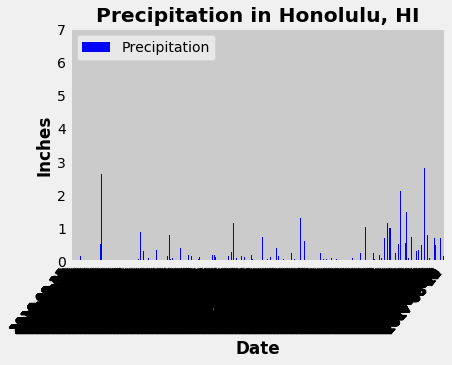

In [66]:
# Use Pandas Plotting to plot the data
# x_axis = precip_data_df['date']
# y_axis = precip_data_df['prcp']
precip_data_df.plot(kind="bar", color="blue")
plt.xlabel("Date", fontweight="black") 
plt.ylabel("Inches", fontweight="black") 
plt.title("Precipitation in Honolulu, HI", fontweight="black") 
#Rotation and horizontal alligment of the date labels
plt.xticks(rotation=50, ha='right')
# plt.yticks(np.arange(0, 300, 50))
plt.show()

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
locations = engine.execute('SELECT * FROM station').fetchall()
locations
# In [7]: titanic.agg({'Age': ['min', 'max', 'median', 'skew'],
#    ...:              'Fare': ['min', 'max', 'median', 'mean']})
#    ...: 
# Out[7]: 
#               Age        Fare
# max     80.000000  512.329200
# mean          NaN   32.204208
# median  28.000000   14.454200
# min      0.420000    0.000000
# skew     0.389108         NaN

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [ ]:
# Design a query to show how many stations are available in this dataset?
locations = engine.execute('SELECT * FROM station').fetchall()

In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
#groupby station name
# List the stations and the counts in descending order.


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
